In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    "emnist",
    split = ["train", "test"],
    shuffle_files = True,
    as_supervised = True, #to use the tfds.show_examples below, this should be false, otherwise make it True
    #for regular training. 
    with_info = True,
)

Metal device set to: Apple M1


2022-02-06 16:18:20.821350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-06 16:18:20.821918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
#print(ds_info)
num_train_examples = ds_info.splits['train'].num_examples
num_test_examples = ds_info.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

class_names= ds_info.features['label'].names
print(class_names)

Number of training examples: 697932
Number of test examples:     116323
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61']


fig = tfds.show_examples(ds_train, ds_info, rows = 4, cols = 4) #this requires that the above as_supervised be False

In [5]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255.
    return images, labels

def transpose(images, labels):
    images = tf.transpose(images)
    return images, labels

In [6]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

# The map function applies the normalize function to each element in the train and test datasets
ds_train = ds_train.map(normalize, num_parallel_calls = AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(normalize, num_parallel_calls = AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(AUTOTUNE)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(62, activation = 'softmax')
])

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 62)                7998      
                                                                 
Total params: 124,990
Trainable params: 124,990
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.fit(ds_train, epochs = 3)

Epoch 1/3


/Users/puravgupta/miniforge3/envs/tensorflow_env/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-02-06 16:20:00.114530: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-06 16:20:00.115110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 16:20:10.146863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 342032 of 697932
2022-02-06 16:20:20.149196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 401213 of 697932
2022-02-06 16:20:30.144681: I tensorflow/core/ker

    9/10906 [..............................] - ETA: 1:11 - loss: 3.9268 - accuracy: 0.0712         

2022-02-06 16:21:22.386493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


10906/10906 [==============================] - 135s 5ms/step - loss: 0.6609 - accuracy: 0.7893
Epoch 2/3
10906/10906 [==============================] - 53s 5ms/step - loss: 0.4961 - accuracy: 0.8289
Epoch 3/3
10906/10906 [==============================] - 53s 5ms/step - loss: 0.4661 - accuracy: 0.8367


In [15]:
model.evaluate(ds_test)

 24/909 [..............................] - ETA: 3s - loss: 0.4184 - accuracy: 0.8473

2022-02-06 16:24:03.502704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


909/909 [==============================] - 4s 4ms/step - loss: 0.4676 - accuracy: 0.8360


[0.4676347076892853, 0.8360427618026733]

In [16]:
for test_images, test_labels in ds_test.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

2022-02-06 19:31:54.257570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [26]:
predictions.shape

(128, 62)

In [27]:
predictions[0]

array([1.9666857e-01, 1.3752919e-08, 1.4835599e-06, 1.2684537e-06,
       2.3719171e-07, 7.7918685e-06, 2.5659399e-05, 7.1224654e-10,
       1.2085215e-08, 1.6119218e-06, 1.0893622e-08, 2.0097568e-07,
       5.3671280e-05, 1.2362226e-04, 2.3419508e-07, 5.6872103e-09,
       1.7946758e-06, 2.2837557e-10, 4.6299441e-08, 2.2273593e-06,
       4.6418114e-14, 5.6155369e-09, 1.7711148e-10, 3.7788768e-09,
       7.6658601e-01, 1.6664989e-08, 1.4871918e-05, 3.7448440e-11,
       2.7322136e-05, 3.9607128e-12, 5.5804185e-06, 9.7363485e-11,
       2.0812518e-10, 6.3523162e-16, 4.3517665e-09, 6.1601566e-12,
       2.5632969e-04, 5.3085837e-06, 2.9122712e-06, 9.2161763e-06,
       8.0835116e-06, 2.1742214e-10, 7.5889116e-06, 1.9412085e-09,
       7.3180632e-07, 6.7779052e-07, 1.4547101e-11, 1.6223680e-07,
       4.7977632e-13, 2.2491536e-08, 3.6175143e-02, 1.9755913e-07,
       1.0810794e-06, 6.1285888e-08, 5.5891824e-06, 4.2881948e-06,
       2.4780675e-07, 3.7407222e-10, 6.2828404e-10, 2.7345582e

In [20]:
np.argmax(predictions[0])


24

In [21]:
test_labels[0]

24

In [31]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(62), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

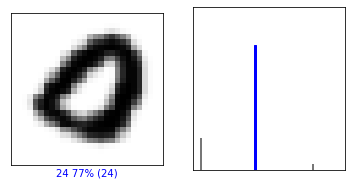

In [33]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

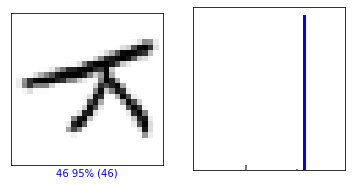

In [40]:
i = 6
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)